# Lecture 10 - Uncertainty Propagation: Perturbative Methods

## Objectives

+ To remember the Taylor expansion of multivaritae real functions
+ To use the Laplace approximation to approximate arbitrary probability densities as Gaussians
+ To use the Taylor expansion and the Laplace approximation to (approximately) propagate uncertainties through models
+ To use the method of adjoints to calculate derivatives of dynamical systems or partial differential equations with respect to uncertain parameters

## Readings

+ None

In [1]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

## The Taylor Expansion in 1D
Let $g:\mathbb{R}\rightarrow\mathbb{R}$ be a smooth real function and $x_0\in\mathbb{R}$.
The [Taylor series expansion](https://en.wikipedia.org/wiki/Taylor_series) of $g(x)$ abount $x_0$ is:
$$
g(x) = g(x_0) + \frac{dg(x_0)}{dx}(x-x_0) + \frac{1}{2}\frac{d^2g(x_0)}{dx^2}(x-x_0)^2+\dots + \frac{1}{n!}\frac{d^ng(x_0)}{dx^n}(x-x_0)^n+\dots
$$
You can use the Taylor expansion to approximate any function as a polynomial.

### Example: 1D Taylor Series Expansion
Take $g(x) = \sin(x)$ and $x_0=0$.
We have:
$$
\frac{dg(0)}{dx} = \cos(x)|_{x=0} = 1,
$$
$$
\frac{d^2g(0)}{dx^2} = -\sin(x)_{x=0} = 0,
$$
$$
\frac{d^3g(0)}{dx^3} = -\cos(x)_{x=0} = -1,
$$
and in general:
$$
\sin(x) = \sum_{k=0}^{\infty} \frac{(-1)^k}{(2k+1)!}x^{2k+1}.
$$

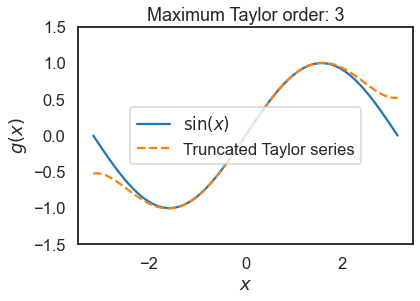

In [2]:
max_taylor_order = 3
fig, ax = plt.subplots()
x = np.linspace(-np.pi, np.pi, 100)
y_true = np.sin(x)
y_taylor = np.zeros(x.shape)
for k in range(max_taylor_order):
    y_taylor += (-1.) ** k * 1. / math.factorial(2 * k + 1) * x ** (2 * k + 1)
ax.plot(x, y_true, label='$\sin(x)$')
ax.plot(x, y_taylor, '--', label='Truncated Taylor series')
plt.legend(loc='best')
ax.set_ylim(-1.5, 1.5)
ax.set_title('Maximum Taylor order: %d' % max_taylor_order)
ax.set_xlabel('$x$')
ax.set_ylabel('$g(x)$');

### Questions

+ Start increasing the maximum order of the series expansion until you get a satisfactory approximation.

## The Taylor Expansion in Higher Dimensions
Let $g:\mathbb{R}^d\rightarrow \mathbb{R}$ and $x_0\in\mathbb{R}^d$.
The Taylor series expansion is:
$$
g(x) = g(x_0) + \sum_{i=1}^d\frac{\partial g(x_0)}{\partial x_i}(x_i-x_{0i})+\frac{1}{2}\sum_{i,j=1}^d\frac{\partial^2g(x_0)}{\partial x_i\partial x_j}(x_i-x_{0i})(x-x_{0j}) + \dots
$$
Another way of writing this is:
$$
g(x) = g(x_0) + \nabla g(x_0)^T(x-x_0) + \frac{1}{2}(x-x_0)^T\nabla^2 g(x_0) (x-x_0),
$$
where the *Jacobian* is defined as:
$$
\nabla g(x_0) = \left(\frac{\partial g(x_0)}{\partial x_1},\dots,\frac{\partial g(x_0)}{\partial x_1}\right),
$$
and the *Hessian* is:
$$
\nabla^2 g(x_0) = \left(\frac{\partial^2g(x_0)}{\partial x_i\partial x_j}\right)_{i,j=1}^d.
$$

## The Laplace Approximation in 1D
If you are not interested in probabilities of rare events, you may approximate any probability density as a Gaussian (assuming that it is sufficiently narrow).
Let $X$ be a random variable with probability density $p(x)$.
Because $p(x)$ is positive, it is better to work with its logarithm.
First, we find the maximum of $\log p(x)$ which is called the *nominal value* (or just maximum):
$$
x_0 = \arg\max_x \log p(x).
$$
Then, we take the Taylor expansion of $\log p(x)$ about $x=x_0$:
$$
\log p(x) = \log p(x_0) + \frac{d\log p(x_0)}{dx} (x-x_0) + \frac{1}{2}\frac{d^2\log p(x_0)}{dx^2} (x-x_0)^2 + \dots.
$$
Since $x_0$ is a critical point of $\log p(x)$, we must have that:
$$
\frac{d\log p(x_0)}{dx} = 0.
$$
So, the expansion becomes:
$$
\log p(x) = \frac{1}{2}\frac{d^2\log p(x_0)}{dx^2} (x-x_0)^2 + \text{const}.
$$
Therefore,
$$
p(x) \propto \exp\left\{ \frac{1}{2}\frac{d^2\log p(x_0)}{dx^2} (x-x_0)^2 \right\}.
$$
Since $x_0$ is a maximum of $\log p(x)$, the matrix $\frac{d^2\log p(x_0)}{dx^2}$ must be a negative number.
Therefore, the number:
$$
c^2 = -\left[\frac{d^2\log p(x_0)}{dx^2}\right]^{-1},
$$
is positive.
By inspection then, we see that:
$$
p(x) \propto \exp\left\{-\frac{(x-x_0)^2}{2c^2}\right\}.
$$
Ignoring all higher order terms, we conclude:
$$
p(x) \approx \mathcal{N}\left(x|x_0, -\left[\frac{d^2\log p(x_0)}{dx^2}\right]^{-1}\right).
$$
This is the Laplace approximation in one dimension.

### Example
Let's just approximate a Gamma distribution with a Gaussian.
We will do a case that works and a case that does not work.

grad minus log p at x0 is:  1.7763568394002505e-09


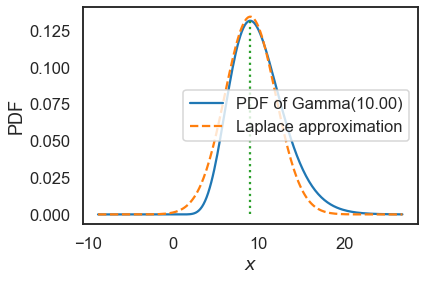

In [3]:
# Construct the ``true random variable``
alpha = 10
X = st.gamma(a=alpha)
# Find the maximum using an optimization method (the minus is because we will use a minimization method)
minus_log_pdf_true = lambda x: -np.log(X.pdf(x))
res = scipy.optimize.minimize_scalar(minus_log_pdf_true, bounds=[1., 8])
# This is the maximum of the pdf
x_0 = res.x
# This is the value of the pdf at the maximum:
p_0 = np.exp(-res.fun)
# The derivative of the pdf at the maximum should be exaclty zero.
# Let's verify it using numerical integration
grad_m_log_p_0 = scipy.misc.derivative(minus_log_pdf_true, x_0, dx=1e-6, n=1)
print('grad minus log p at x0 is: ', grad_m_log_p_0)
# We need the second derivative.
# We will get it using numerical integration as well:
grad_2_m_log_p_0 = scipy.misc.derivative(minus_log_pdf_true, x_0, dx=1e-6, n=2)
# The standard deviation of the Gaussian approximation to p(x) is:
c = np.sqrt(1. / grad_2_m_log_p_0)
# Using scipy code, the random variable that approximates X is:
Z = st.norm(loc=x_0, scale=c)
# Let's plot everything
fig, ax = plt.subplots()
x = np.linspace(x_0 - 6 * c, x_0 + 6 * c, 200)
pdf_true = X.pdf(x)
# Plot the truth:
ax.plot(x, pdf_true)
# Mark the location of the maximum:
# Plot the approximation
ax.plot(x, Z.pdf(x), '--')
ax.plot([x_0] * 10, np.linspace(0, p_0, 10), ':')
plt.legend(['PDF of Gamma(%.2f)' % alpha, 'Laplace approximation'], loc='best')
ax.set_xlabel('$x$')
ax.set_ylabel('PDF');

## The Laplace Approximation in Many Dimensions
Then, we take the Taylor expansion of $\log p(x)$ about $x=x_0$:
$$
\log p(x) = \log p(x_0) + \nabla \log p(x_0) (x-x_0) + \frac{1}{2}(x-x_0)^T\nabla^2 \log p(x_0) (x-x_0) + \dots.
$$
Since $x_0$ is a critical point of $\log p(x)$, we must have that:
$$
\nabla \log p(x_0) = 0.
$$
So, the expansion becomes:
$$
\log p(x) = \frac{1}{2}(x-x_0)^T\nabla^2 \log p(x_0) (x-x_0) + \text{const}.
$$
Therefore,
$$
p(x) \propto \exp\left\{ \frac{1}{2}(x-x_0)^T\nabla^2 \log p(x_0) (x-x_0) \right\}.
$$
Since $x_0$ is a maximum of $\log p(x)$, the matrix $\nabla^2 \log p(x_0)$ must be negative definite.
Therefore, the matrix:
$$
C = -(\nabla^2\log p(x_0))^{-1},
$$
is positive definite.
By inspection then, we see that:
$$
p(x) \propto \exp\left\{-\frac{1}{2}(x-x_0)^TC^{-1}(x-x_0)\right\}.
$$
Ignoring all higher order terms, we conclude:
$$
p(x) \approx \mathcal{N}\left(x|x_0, -(\nabla^2\log p(x_0))^{-1}\right).
$$
This is the Laplace approximation in many dimensions.

### Questions

+ Experiment with various values of alpha for the true Gamma distribution. What happens when alpha is smaller than one. Why doesn't the method work at for that parameter?

## Perturbation Approach in 1D

Let $X\sim p$ be a random vector and $Y=f(X)$ a scalar quantity of interest that depends on $X$.
Our goal is to estimate the first order statistics of $Y$.
In particular, the mean:
$$
\mathbb{E}[f(X)] = \int f(x) p(x)dx,
$$
and the variance:
$$
\mathbb{V}[f(X)] = \int \left(f(x)-\mathbb{E}[f(X)]\right)^2p(x)dx.
$$
First, we take the laplace approximation for the random vector and approximate its density as a Gaussian.
That is, we write:
$$
p(x) \approx \mathcal{N}\left(x|\mu, \sigma^2\right),
$$
with $\mu$ and $\Sigma$ as given by the Laplace approximation.
Now, we take the Taylor expansion of $f(x)$ around $x=\mu$:
$$
f(x) = f(\mu) + \frac{df(\mu)}{dx} (x-\mu)+\dots
$$
Now, let's take the expecation over the Laplace approximation of $p(x)$.
$$
\begin{array}{ccc}
\mathbb{E}[f(X)] &=& \mathbb{E}\left[f(\mu) + \frac{df(\mu)}{dx} (X-\mu) + \dots\right]\\
&=& f(\mu) + \frac{df(\mu)}{dx}\mathbb{E}[X-\mu] + \dots\\
&=& f(\mu) + \dots
\end{array}
$$
So, to *second order* we have:
$$
\mathbb{E}[f(X)] \approx f(\mu).
$$
You can, of course, construct higher order approximations in this way.

Let's now do the variance.
We will use the formula:
$$
\mathbb{V}[f(X)] = \mathbb{E}[f^2(X)] - \left[\mathbb{E}[f(X)]\right]^2.
$$
Keeping up to second order terms, we get:
$$
\begin{array}{ccc}
\mathbb{E}[f^2(X)] &=& \mathbb{E}\left[\left(f(\mu) + \frac{df(\mu)}{dx} (X-\mu) + \dots\right)^2\right]\\
&=& f^2(\mu) + \left(\frac{df(\mu)}{dx}\right)^2\mathbb{E}[(X-\mu)^2] + 2f(\mu)\frac{df(\mu)}{dx}\mathbb{E}[X-\mu] + \dots\\
&=& f^2(\mu) + \left(\frac{df(\mu)}{dx}\right)^2\sigma^2 + \dots
\end{array}
$$
Therefore, for the variance we get:
$$
\begin{array}{ccc}
\mathbb{V}[f(X)] &=& f^2(\mu) + \left(\frac{df(\mu)}{dx}\right)^2\sigma^2 + \dots - \left(f(\mu) + \dots\right)^2\\
&=& f^2(\mu) + \left(\frac{df(\mu)}{dx}\right)^2\sigma^2 - f^2(\mu) + \dots\\
&=& \left(\frac{df(\mu)}{dx}\right)^2\sigma^2 + \dots
\end{array}
$$
So, to *first order* we have:
$$
\mathbb{V}[f(X)] \approx \left(\frac{df(\mu)}{dx}\right)^2\sigma^2
$$
And, of course, we can go to higher order approximations.

Now, having approximations for the mean and the variance, we may approximate the full density of the random variable $Y=f(X)$ by a Gaussian:
$$
p(y) \approx \mathcal{N}\left(y|f(\mu), \left(\frac{df(\mu)}{dx}\right)^2\sigma^2\right).
$$

### Example: 1D Propagation of Uncertainty

Let's solve a (very simple) uncertainty propagation problem using these techniques.
Consider:
$$
X\sim \mathcal{N}(\pi/2, 0.1^2),
$$
and
$$
f(x) = \sin(x) e^{-0.5x}.
$$
We have:

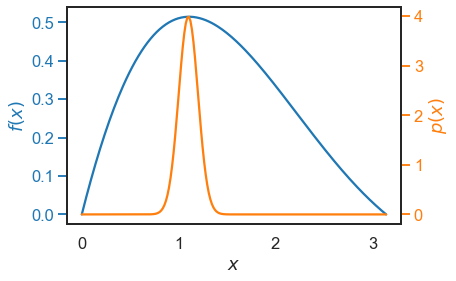

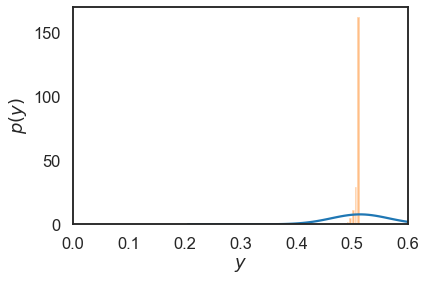

In [7]:
# Defining the densit of X:
mu = 1.1
sigma = 0.1
X = st.norm(loc=mu, scale=sigma)
# The function through which we want to propagate uncertainties
f = lambda x: np.sin(x) * np.exp(-0.5 * x)
fig1, ax1 = plt.subplots()
x = np.linspace(0., np.pi, 200)
ax1.plot(x, f(x))
ax1.set_xlabel('$x$')
ax1.set_ylabel('$f(x)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
ax2 = ax1.twinx()
ax2.plot(x, X.pdf(x), color=sns.color_palette()[1])
ax2.set_ylabel('$p(x)$', color=sns.color_palette()[1])
ax2.tick_params('y', colors=sns.color_palette()[1])
# The function at mu
f_at_mu = f(mu)
# The first derivative of the function at mu
df_at_mu = scipy.misc.derivative(f, mu, dx=1e-8, n=1)
# We can now construct a Gaussian approximation to the distribution of f(X)
exp_f_X = f_at_mu
var_f_X = f_at_mu ** 2 * sigma ** 2
f_X = st.norm(loc=exp_f_X, scale=np.sqrt(var_f_X))
# We will compare to the histogram of 10,000 samples
y_samples = [f(X.rvs()) for _ in range(10000)]
fig, ax = plt.subplots()
y = np.linspace(exp_f_X - 6 * np.sqrt(var_f_X), exp_f_X + 6 * np.sqrt(var_f_X), 100)
ax.plot(y, f_X.pdf(y))
ax.set_xlim(0., 0.6)
ax.hist(y_samples, bins=10, density=True, alpha=0.5);
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$');

## Perturbation Approach in Many Dimensions

Let $X\sim\mathcal{N}(\mu,\Sigma)$ be a d-dimensional Gaussian random vector.
If $X$ was not Gaussian, we could use the Laplace approximation.
Let $f(x)$ be a m-dimensional function of $x$:
$$
f:\mathbb{R}^d\rightarrow \mathbb{R}^m.
$$
To get the Taylor series expansion of $f(x)$, you need to work out the Taylor series expansion of each output component and put everything back together.
You will get:
$$
f(x) = f(\mu) + \nabla f(\mu) (x - \mu) + \dots,
$$
where $\nabla f(\mu)\in\mathbb{R}^{m\times d}$ is the Jacobian matrix defined by:
$$
\nabla f(\mu) = \left(
\begin{array}{ccc}
\frac{\partial f_1(\mu)}{\partial x_1} & \dots & \frac{\partial f_1(\mu)}{\partial x_d}\\
\vdots & \ddots & \vdots\\
\frac{\partial f_m(\mu)}{\partial x_1} & \dots & \frac{\partial f_m(\mu)}{\partial x_d}
\end{array}
\right)
$$

To first order, the expectation of $Y = f(X)$ is:
$$
\mathbb{E}[f(X)] \approx f(\mu),
$$
while the covariance matrix is:
$$
\mathbb{C}[f(X)] \approx \nabla f(\mu)\Sigma \left(\nabla f(\mu)\right)^T,
$$

Putting these two things together, we may approximate the density of $Y=f(X)$ with a multivariate Gaussian:
$$
p(y) \approx \mathcal{N}\left(y|f(\mu), \nabla f(\mu)\Sigma \left(\nabla f(\mu)\right)^T\right).
$$

## Perturbation Approach for Stochastic Dynamical Systems with Low Dimensional, Small Uncertainties
Potentially using the Laplace approximation, assume that we have a $d$-dimensional random vector:
$$
X\sim\mathcal{N}(\mu, \Sigma).
$$
Consider the $m$-dimensional dynamical system:
$$
\frac{dy}{dt} = g(y;X),
$$
with initial conditions
$$
y(0) = y_0(X).
$$
Since $X$ is a random vector, the response of the dynamical system $Y(t)$ is a stochastic process:
$$
Y(t) = y(t; X),
$$
where $y(t;X)$ is the solution of the initial value problem for a specific realization of the random vector $X$. 
We will approximate this stochastic process with a Gaussian process:
$$
Y(\cdot) \sim \text{GP}\left(m(\cdot), k(\cdot, \cdot)\right).
$$
This can easily be done, using the results of the previous sections.
The mean is:
$$
m(t) = \mathbb{E}[Y(t)] = \mathbb{E}[y(t;X)] = y(t;\mu).
$$
The covariance between two times is:
$$
k(t,t') = \mathbb{C}[Y(t), Y(t')] = \mathbb{C}[y(t;X), y(t';X)] = \nabla_x y(t;\mu) \Sigma \left(\nabla_x y(t';\mu)\right)^T.
$$
The only complicating factor, is that we need a way to get $\nabla_x y(t;\mu)$.
For this, we need the method of adjoints.

## Calculating Sensitivities in Dynamical Systems using the Method of Ajdoints
We will show how we can compute $\nabla_x y(t;\mu)$ using the method of adjoints.
The idea is simple.
We will derive the differential equation that $\nabla_x y(t;\mu)$ satisfies and we will be solving it as we solve for $y(t;\mu)$.
Let $i\in\{1,\dots,m\}$ and $j\in\{1,\dots,d\}$.
We start with the initial conditions.
We have:
$$
\frac{\partial y_i(0;\mu)}{\partial x_j} = \frac{\partial y_{0i}(\mu)}{\partial x_j}.
$$
Now, let's do the derivatives:
$$
\begin{array}{ccc}
\frac{d}{dt}\frac{\partial y_i(t;\mu)}{\partial x_j} &=& \frac{\partial }{\partial x_j}\frac{dy_i(t,\mu)}{dt} \\
&=& \frac{\partial }{\partial x_j} g_i(y(t;\mu); \mu)\\
&=& \sum_{r=1}^m\frac{\partial g_i(y(t;\mu); \mu)}{\partial y_r}\frac{\partial y_r(t;\mu)}{\partial x_j} + \frac{\partial g_i(y(t;\mu); \mu)}{\partial x_j}.
\end{array}
$$

So, we see that the dynamical system that $\nabla_x y(t;\mu)$ satisfies is:
$$
\frac{d}{dt}\nabla_x y(t;\mu) =  \left((\nabla_y g(y;\mu)\right)^T \nabla_x y(t;\mu) + \nabla_x g(y;\mu),
$$
with initial conditions
$$
\nabla_x y(0;\mu) = \nabla_x y_0(\mu).
$$
This is known as the *adjoint dynamical* system.

### Example: Dynamical System with Uncertain Paramters

Take the random vector:
$$
X = (X_1, X_2),
$$
and assume that the components are independent Gaussian:
$$
X_i \sim \mathcal{N}(\mu_i, \sigma_i^2).
$$
So, for the full random vector we have a mean:
$$
\mu = (\mu_1, \mu_2),
$$
and a covariance matrix:
$$
\Sigma = \operatorname{diag}(\sigma_1^2,\sigma_2^2).
$$

Consider the ODE:
  \begin{align*}
    &\dot{y} = \frac{d y(t)}{dt} =-X_1y(t) \equiv g(y,X),\\
    &\qquad y(0) = X_2 \equiv y_0(X).
  \end{align*}
The adjoint system describes the evolution of the derivative:
$$
\nabla_x y(t;\mu) = \left(\frac{\partial y(t;\mu)}{\partial x_1}, \frac{\partial y(t;\mu)}{\partial x_2}\right).
$$
According to the formulas, we wrote before we need:
$$
\nabla_x y_0(\mu) = (0, 1),
$$
$$
\frac{\partial g(y;\mu)}{\partial y} = -\mu_1,
$$
and
$$
\nabla_x g(y;\mu) = (-y, 0).
$$

Putting everything together, the adjoint dynamical system is:
$$
\begin{array}{ccc}
\frac{d}{dt}\frac{\partial y}{\partial x_1} &=& -x_1 \frac{\partial y}{\partial x_1} - y,\\
\frac{d}{dt}\frac{\partial y}{\partial x_2} &=& -x_1 \frac{\partial y}{\partial x_2},\\
\end{array}
$$
with initial conditions:
$$
\begin{array}{ccc}
\frac{d}{dt}\frac{\partial y(0)}{\partial x_1} &=& 0,\\
\frac{d}{dt}\frac{\partial y(0)}{\partial x_2} &=& 1.
\end{array}
$$

In [8]:
# Let's extend the solver object we had before so that it also gives the adjoint solution
import scipy.integrate

class Ex1Solver(object):
    """
    An object that can solver the afforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 2 elements. This represents the stochastic input x = (x1, x2).
        """
        # The dynamics of the adjoint z = y, dy/dx1, dy/dx2
        def g(z, t, x):
            return -x[0] * z[0], -x[0] * z[1] - z[0], -x[0] * z[2]
        # The initial condition
        y0 = (x[1], 0, 1)
        # We are ready to solve the ODE
        y = scipy.integrate.odeint(g, y0, self.t, args=(x,))
        return y

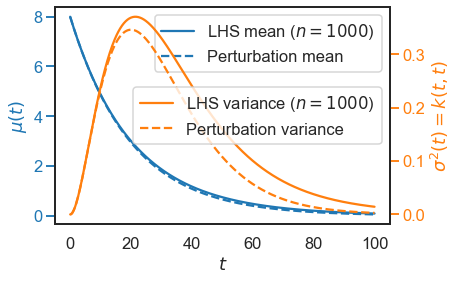

In [9]:
mu = np.array([0.05, 8.])
Sigma = np.diag([0.01 ** 2, 0.01 ** 2])
solver = Ex1Solver(nt=500, T=100)
z_at_mu = solver(mu)
y_at_mu = z_at_mu[:, 0]
grad_x_y_at_mu = z_at_mu[:, 1:]
C = np.dot(grad_x_y_at_mu, np.dot(Sigma, grad_x_y_at_mu.T))

# For comparison, let's compute the mean and the variance with 1,000 LHS samples
import pyDOE
num_lhs = 1000
X_lhs = pyDOE.lhs(2, num_lhs) # These are uniformly distributed - Turn them to standard normal
X_samples = mu + np.dot(st.norm.ppf(X_lhs), np.sqrt(Sigma))
s = 0.
s2 = 0.
for x in X_samples:
    y = solver(x)[:, 0]
    s += y
    s2 += y ** 2
y_mu_lhs = s / num_lhs
y_var_lhs = s2 / num_lhs - y_mu_lhs ** 2

# Make the figure
fig1, ax1 = plt.subplots()

# Plot the mean and compare to LHS
ax1.plot(solver.t, y_mu_lhs, color=sns.color_palette()[0], label='LHS mean ($n=%d$)' % num_lhs)
ax1.plot(solver.t, y_at_mu, '--', color=sns.color_palette()[0], label='Perturbation mean')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$\mu(t)$', color=sns.color_palette()[0])
ax1.tick_params('y', colors=sns.color_palette()[0])
plt.legend(loc='upper right')

# Plot variance and compare to LHS
ax2 = ax1.twinx()
ax2.plot(solver.t, y_var_lhs, color=sns.color_palette()[1], label='LHS variance ($n=%d$)' % num_lhs)
ax2.plot(solver.t, np.diag(C), '--', color=sns.color_palette()[1], label='Perturbation variance')
ax2.set_ylabel('$\sigma^2(t) = k(t, t)$', color=sns.color_palette()[1])
ax2.tick_params('y', colors=sns.color_palette()[1])
plt.legend(loc='center right');

Text(0, 0.5, '$y(t)$')

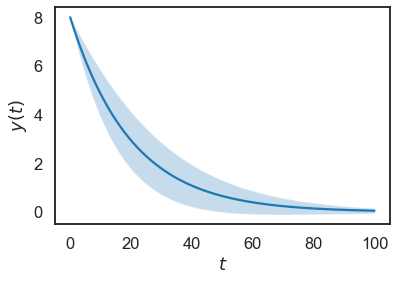

In [10]:
# Let's do 95% intervals
s = np.sqrt(np.diag(C))
l = y_at_mu - 2 * s
u = y_at_mu + 2 * s
fig, ax = plt.subplots()
ax.plot(solver.t, y_at_mu)
ax.fill_between(solver.t, l, u, alpha=0.25)
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')

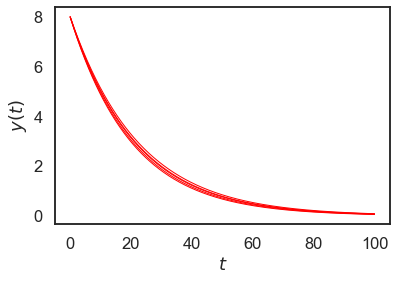

In [11]:
# Let's take some sample paths
L = np.linalg.cholesky(C + 1e-10 * np.eye(C.shape[0])) # add something to the diagonal for numerical stability
fig, ax = plt.subplots()
ax.set_xlabel('$t$')
ax.set_ylabel('$y(t)$')
for _ in range(5):
    xi = np.random.randn(L.shape[0])
    y = y_at_mu + np.dot(L, xi)
    ax.plot(solver.t, y, 'r', lw=1)

### Questions

+ Repeat the above analysis with a smaller variance for $X$, say $1/10$'th of the original one. Is the comparision between the sampling and the perturbation approach closer or further away?

+ Repeaqt the above analysis with a larger variance for $X$, say $2$ times the original one. Is the comparision between the sampling and the perturbation approach closer or further away?